In [1]:
import cProfile
import jax
import lsdb
import os
import numpy as np
import pandas as pd
import photod.locus as lt
import photod.bayes as bt

pd.set_option('display.max_columns', None)
jax.config.update('jax_platform_name', 'cpu')

Read photometric catalog with stars, for this we already prepared a small dataset based on SDSS S82.

Željko's pipeline example based on simulated TRILEGAL data had additionally the following cuts (only the first one can be implemented in S82): 
 - The input data are limited to 0.2 < g-i < 3.0 and 
 - -2.5 < FeH < 0 (probably OK in S82, maybe a few outliers) 
 - Mr > -1.0 (no very bright giants)
 - log(g) < 7 (no WDs, probably a small fraction exists in S82)
 - rmag < 26 (SDSS limiting mag is r~24, so this is not needed)

In [2]:
from dask.distributed import Client

client = Client(n_workers=96, threads_per_worker=1, memory_limit="15GiB")
client

/nvme/lovro/miniconda3/envs/photod-testing/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34511 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:34511/status,
Dashboard: http://127.0.0.1:34511/status,Workers: 96
Total threads: 96,Total memory: 1.41 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44481,Workers: 96
Dashboard: http://127.0.0.1:34511/status,Total threads: 96
Started: Just now,Total memory: 1.41 TiB
Comm: tcp://127.0.0.1:36215,Total threads: 1
Dashboard: http://127.0.0.1:43479/status,Memory: 15.00 GiB
Nanny: tcp://127.0.0.1:40769,


In [48]:
%%time 
s82 = lsdb.read_hats("/mnt/beegfs/scratch/data/S82_standards/S82_hats/S82_hats_fixed/")
#s82.skymap(lambda df, a: np.log10(len(df)+1), order=9)

CPU times: user 15.3 ms, sys: 3.27 ms, total: 18.6 ms
Wall time: 18.3 ms


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - S82_fixed'}>)

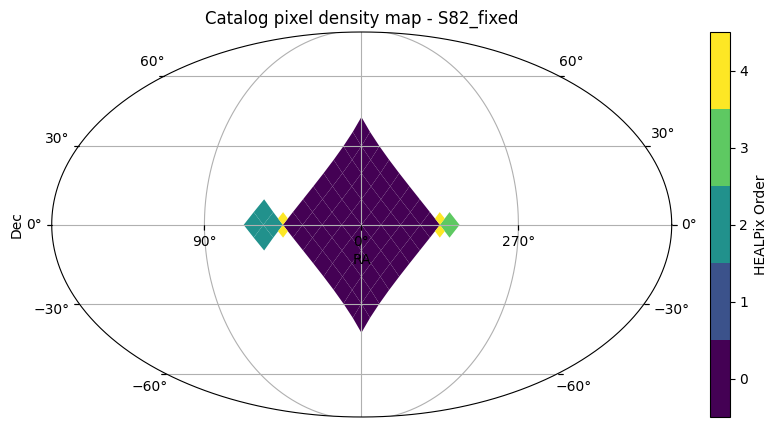

In [10]:
s82.plot_pixels()

In [49]:
s82=s82.compute()

In [50]:
s82 = pd.DataFrame(s82.to_records())
s82

,_healpix_29,CALIBSTARS,ra,dec,RArms,Decrms,Ntot,Ar,uNobs,umag,ummu,uErr,umrms,umchi2,gNobs,gmag,gmmu,gErr,gmrms,gmchi2,rNobs,rmag,rmmu,rErr,rmrms,rmchi2,iNobs,imag,immu,iErr,imrms,imchi2,zNobs,zmag,zmmu,zErr,zmrms,zmchi2,Norder,Dir,Npix,Mr,FeH,MrEst,MrEstUnc,FeHEst,ug,gr,gi,ri,iz,ugErr,grErr,giErr,riErr,izErr,glon,glat
0,178820370416688,CALIBSTARS_0891163,43.787097,1.037784,0.0282,0.0282,24,0.256,23,19.544,19.547,0.007,0.044,1.034,22,17.958,17.958,0.004,0.015,0.710,21,17.287,17.288,0.003,0.004,0.302,22,17.024,17.027,0.003,0.014,0.949,23,16.886,16.891,0.004,0.017,0.835,4,0,0,-99,-99,-99,-99,-99,1.586,0.671,0.934,0.263,0.138,0.008062,0.005000,0.005000,0.004243,0.005000,174.537601,-49.030895
1,178775253286992,CALIBSTARS_0891187,43.828101,1.040223,0.4066,0.4066,47,0.253,24,18.470,18.469,0.005,0.028,1.098,24,17.380,17.378,0.004,0.019,1.014,23,16.973,16.973,0.003,0.013,0.944,23,16.812,16.810,0.003,0.009,0.627,24,16.748,16.750,0.004,0.011,0.611,4,0,0,-99,-99,-99,-99,-99,1.090,0.407,0.568,0.161,0.064,0.006403,0.005000,0.005000,0.004243,0.005000,174.579778,-49.000538
2,178692611270558,CALIBSTARS_0891200,43.831573,1.024147,0.0315,0.0315,25,0.254,8,22.873,22.887,0.136,0.150,0.342,24,20.266,20.267,0.006,0.022,0.760,23,18.816,18.814,0.004,0.009,0.450,25,18.018,18.023,0.003,0.015,0.829,25,17.567,17.566,0.005,0.018,0.706,4,0,0,-99,-99,-99,-99,-99,2.607,1.450,2.248,0.798,0.451,0.136132,0.007211,0.006708,0.005000,0.005831,174.600676,-49.009624
3,178139752091901,CALIBSTARS_0891206,43.870259,0.983584,0.0259,0.0259,25,0.253,25,21.136,21.113,0.019,0.090,0.760,25,19.771,19.775,0.005,0.019,0.586,25,19.245,19.242,0.004,0.016,0.742,25,19.030,19.033,0.004,0.017,0.784,24,18.919,18.924,0.010,0.036,0.787,4,0,0,-99,-99,-99,-99,-99,1.365,0.526,0.741,0.215,0.111,0.019647,0.006403,0.006403,0.005657,0.010770,174.686073,-49.011621
4,178442591206321,CALIBSTARS_0891209,43.884348,1.028387,0.0506,0.0506,25,0.251,25,19.421,19.411,0.007,0.036,1.130,25,17.740,17.738,0.004,0.021,0.949,25,17.089,17.090,0.003,0.011,0.764,24,16.850,16.848,0.003,0.016,1.029,23,16.731,16.730,0.004,0.014,0.744,4,0,0,-99,-99,-99,-99,-99,1.681,0.651,0.890,0.239,0.119,0.008062,0.005000,0.005000,0.004243,0.005000,174.653707,-48.969732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952395,3458587837391950679,CALIBSTARS_0218913,316.124689,-0.984808,0.0322,0.0322,16,0.175,12,21.903,21.876,0.058,0.182,0.693,14,21.165,21.165,0.013,0.032,0.688,15,20.899,20.895,0.013,0.036,0.570,16,20.793,20.768,0.017,0.051,0.701,10,20.744,20.665,0.066,0.158,0.791,4,0,3071,-99,-99,-99,-99,-99,0.738,0.266,0.372,0.106,0.049,0.059439,0.018385,0.021401,0.021401,0.068154,48.618385,-29.731558
952396,3458588330308145677,CALIBSTARS_0218915,316.057052,-0.958560,0.0349,0.0349,15,0.185,9,22.975,22.955,0.138,0.163,0.371,15,21.535,21.545,0.017,0.071,0.908,14,21.020,21.002,0.015,0.055,1.019,15,20.820,20.774,0.017,0.068,1.157,13,20.602,20.582,0.054,0.096,0.502,4,0,3071,-99,-99,-99,-99,-99,1.440,0.515,0.715,0.200,0.218,0.139043,0.022672,0.024042,0.022672,0.056613,48.604161,-29.660076
952397,3458587856950236370,CALIBSTARS_0218917,316.133306,-0.971373,0.0410,0.0410,16,0.174,3,24.789,24.878,0.611,0.090,0.095,13,22.356,22.341,0.034,0.075,0.577,16,21.081,21.081,0.015,0.061,0.923,16,20.525,20.510,0.013,0.057,1.156,13,20.048,20.061,0.034,0.200,1.482,4,0,3071,-99,-99,-99,-99,-99,2.433,1.275,1.831,0.556,0.477,0.611945,0.037162,0.036401,0.019849,0.036401,48.636757,-29.732016
952398,3458585732920967238,CALIBSTARS_0218918,316.174186,-1.044566,0.0474,0.0474,26,0.177,7,22.501,22.493,0.110,0.065,0.192,21,21.422,21.401,0.013,0.086,1.437,20,20.976,20.959,0.011,0.065,1.140,21,20.750,20.741,0.014,0.067,0.846,19,20.744,20.697,0.047,0.119,0.617,4,0,3071,-99,-99,-99,-99,-99,1.079,0.446,0.672,0.226,0.006,0.110766,0.017029,0.019105,0.017804,0.049041,48.588761,-29.804763


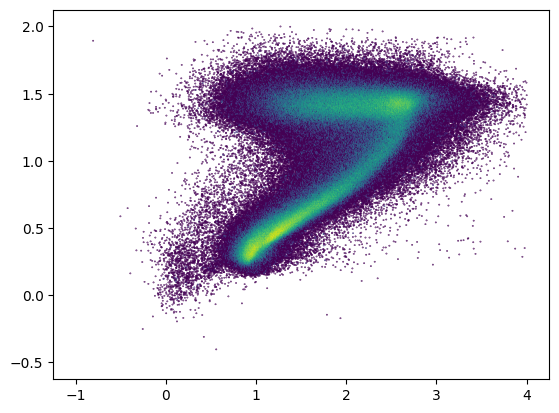

In [47]:
import matplotlib.pyplot as plt

plt.hexbin(s82.ug, s82.gr, gridsize=1000, extent=(-1,4,-0.5,2), mincnt=1, bins="log") #, norm="log")

In [34]:
plt.hexbin?

Signature:
plt.hexbin(
    x: 'ArrayLike',
    y: 'ArrayLike',
    C: 'ArrayLike | None' = None,
    gridsize: 'int | tuple[int, int]' = 100,
    bins: "Literal['log'] | int | Sequence[float] | None" = None,
    xscale: "Literal['linear', 'log']" = 'linear',
    yscale: "Literal['linear', 'log']" = 'linear',
    extent: 'tuple[float, float, float, float] | None' = None,
    cmap: 'str | Colormap | None' = None,
    norm: 'str | Normalize | None' = None,
    vmin: 'float | None' = None,
    vmax: 'float | None' = None,
    alpha: 'float | None' = None,
    linewidths: 'float | None' = None,
    edgecolors: "Literal['face', 'none'] | ColorType" = 'face',
    reduce_C_function: 'Callable[[np.ndarray | list[float]], float]' = <function mean at 0x7f3964419f30>,
    mincnt: 'int | None' = None,
    marginals: 'bool' = False,
    *,
    data=None,
    **kwargs,
) -> 'PolyCollection'
Docstring:
Make a 2D hexagonal binning plot of points *x*, *y*.

If *C* is *None*, the value of the hexagon is 

# Scratch space

Next, read the stellar locus parametrization.

In [5]:
LSSTlocus = lt.LSSTsimsLocus(fixForStripe82=False) # fixForStripe82 was originally set to False
## select the color range where we expect main sequence and red giants
OKlocus = LSSTlocus[(LSSTlocus['gi']>0.2)&(LSSTlocus['gi']<3.55)]   # gives MrMax < 15 (rerun priors!)

# LSSTlocus = lt.LSSTsimsLocus(fixForStripe82=False, datafile="/home/scampos/photoD/data/MSandRGBcolors_v1.3.txt") # fixForStripe82 was originally set to False

Subsample Mr and FeH grids (linear speed-up but somewhat lower accuracy)

In [30]:
kMr = 1 # 10x less samples
kFeH = 1 # 2x less samples
locusData = lt.subsampleLocusData(OKlocus, kMr, kFeH)

subsampled locus 2D grid in FeH and Mr from 51 1559 to: 51 1559


Prepare the priors, see TRILEGAL-makePriors-forS82.ipynb notebook (work in progress).

Process data...

In [31]:
fitColors = ('ug', 'gr', 'ri', 'iz')
pix_order = 5
pix_index = 0
# /mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5/0
# priorsRootName = f'/mnt/beegfs/scratch/scampos/photod/priors/TRILEGAL/S82/{pix_order}/{pix_index}'
priorsRootName = f'/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/{pix_order}/{pix_index}'

Make 3D locus list with three ArGrid limits and resolutions.

In [32]:
ArGridList, locus3DList = lt.get3DmodelList(locusData, fitColors)

Select a range of stars to process.

In [33]:
df = s82.pixel_search([(pix_order,pix_index)]).compute().reset_index(drop=True)

In [34]:
iStart = 0
iEnd = len(df)
myStars = [0,100] # [0, 100, 1000, 10000] # for illustration, make plots for these stars
# myStars = [] # [0, 100, 1000, 10000] # for illustration, make plots for these stars

In [35]:
from photod.parameters import GlobalParams

global_params = GlobalParams(
    fitColors=fitColors,
    locusData=locusData,
    ArGridList=ArGridList,
    locus3DList=locus3DList,
    priorsRootName=priorsRootName,
)

with cProfile.Profile() as profiler:
    results, estimates_df = bt.make_bayes_estimates_3d(df, global_params, iStart, iEnd)
    profiler.dump_stats("bayes-3d.pstat")

In [37]:
estimates_df

,glon,glat,FeHEst,FeHUnc,MrEst,MrUnc,chi2min,MrdS,FeHdS,ArEst,ArUnc,ArdS
0,174.537601,-49.030895,-0.861076,0.111762,5.738671,0.174311,9.794025,-360.387939,-37.284000,0.376434,0.038918,-198.501709
1,174.579778,-49.000538,-1.288962,0.108574,4.113915,0.446822,5.601110,-275.867798,-41.320602,0.310352,0.087483,-165.121307
2,174.600676,-49.009624,-1.953770,0.382676,9.954291,0.206572,16.457098,-437.755920,-16.393415,0.192645,0.019645,-247.802582
3,174.686073,-49.011621,-0.900849,0.307892,3.530967,1.543749,1.494736,-222.195190,-18.165440,0.244341,0.175047,-140.626419
4,174.653707,-48.969732,-0.586550,0.119762,5.721495,0.181992,17.395958,-346.850830,-33.097012,0.211843,0.038416,-199.440536
...,...,...,...,...,...,...,...,...,...,...,...,...
3976,176.945849,-47.336167,-0.633173,0.071835,5.020063,0.170686,17.329466,-317.232788,-36.156807,0.107109,0.037478,-201.290329
3977,177.085939,-47.282103,-0.206654,0.086026,5.777800,0.135693,110.020172,-394.317627,-30.895050,0.101309,0.030556,-215.996017
3978,176.930182,-47.116265,-0.193709,0.159062,4.906885,1.554926,38.492165,-341.181763,-23.040083,0.420338,0.119685,-204.767838
3979,177.134561,-46.988405,-0.773920,0.076352,4.586991,0.205407,7.996999,-305.294373,-35.791313,0.342612,0.040143,-196.273102


In [38]:
# Create directories for the plots and results
os.makedirs("plots", exist_ok=True)
os.makedirs("results", exist_ok=True)

In [39]:
# Save estimates to disk
outfile = 'results/S82_Bayes_estimates2.txt'
estimates_df.to_csv(outfile, index=False)

Mr1d= -1.0 14.58 1559
MrBright, MrFaint= -1.0 14.58
Plotting star 0
pts: 51 1559


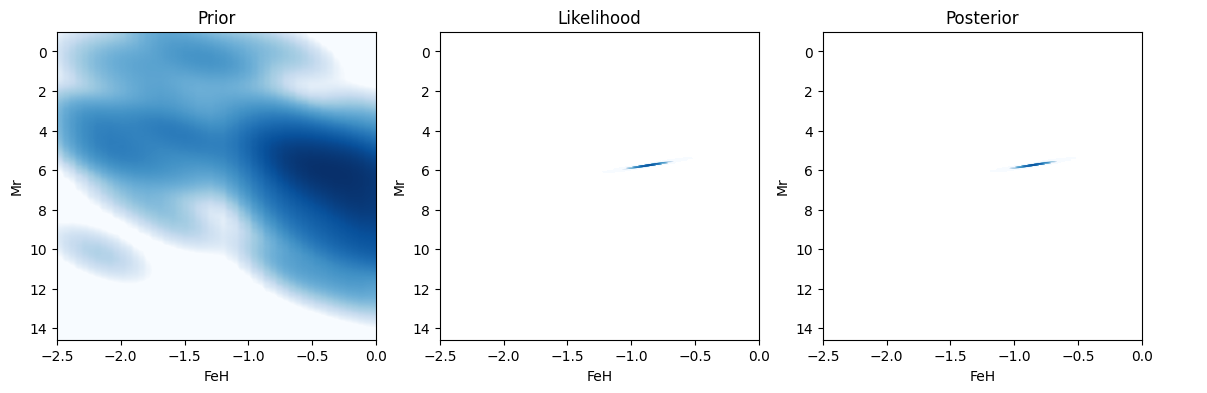

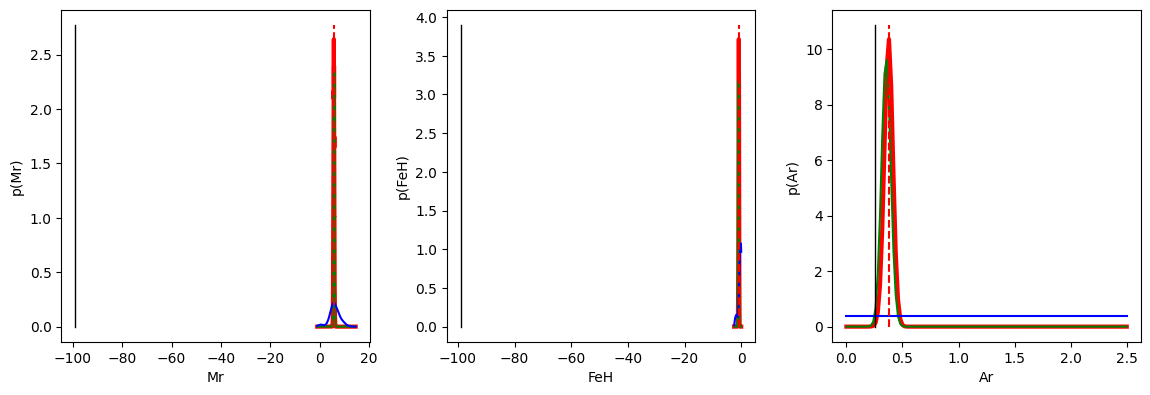

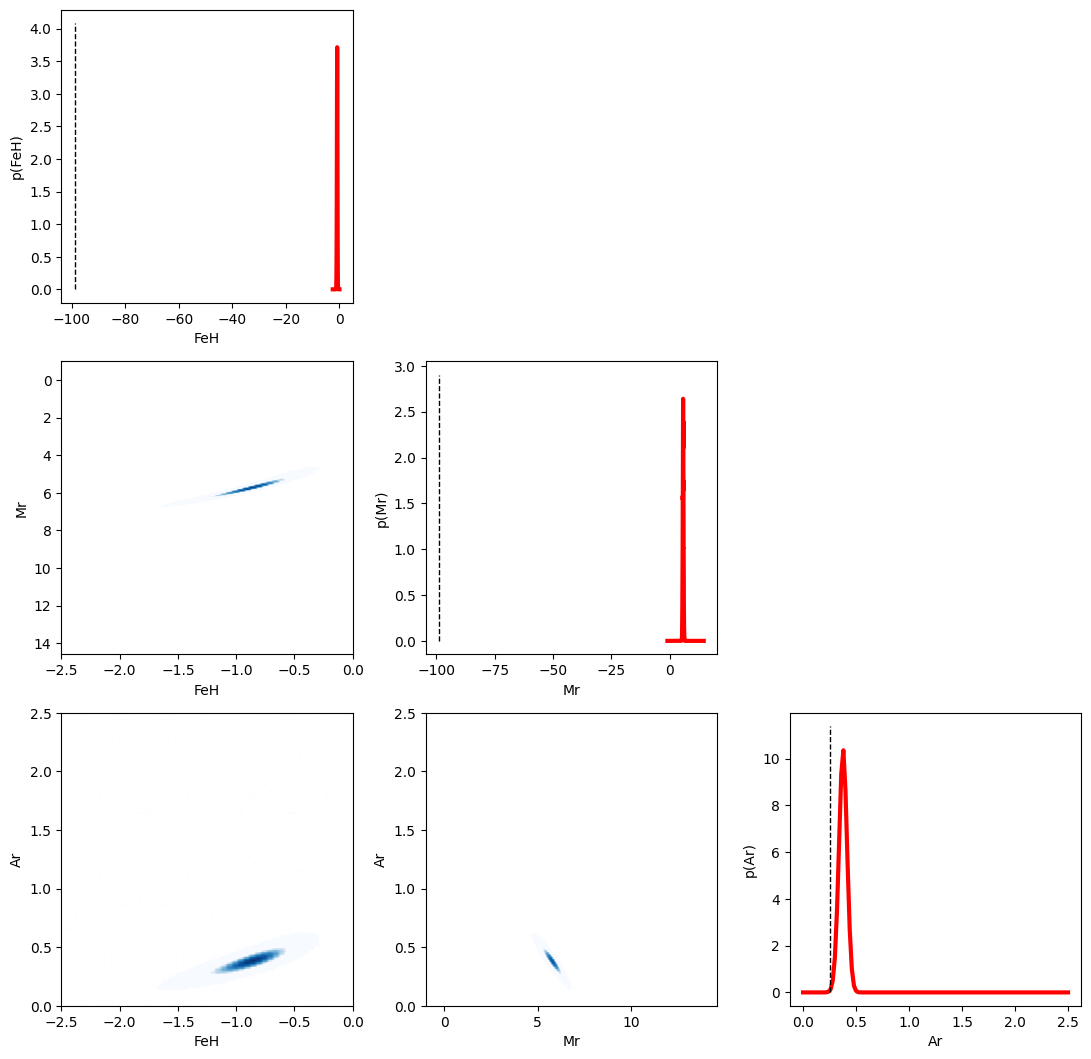

In [ ]:
# Plot the results for two of the stars
bt.plot_stars(df, *results.get_plotting_args(), *global_params.get_plotting_args(), plotStars=myStars)

Mr1d= -1.0 14.4 155
MrBright, MrFaint= -1.0 14.4
Plotting star 0
pts: 25 155


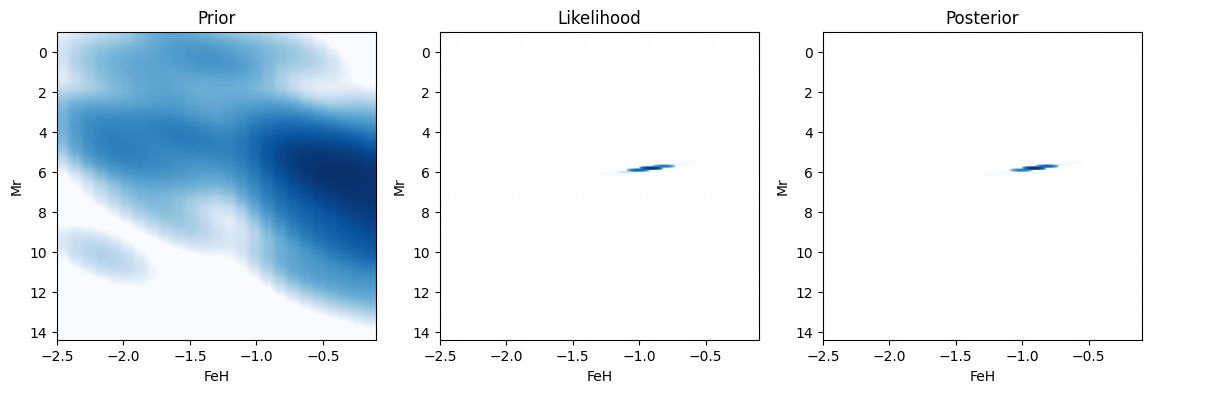

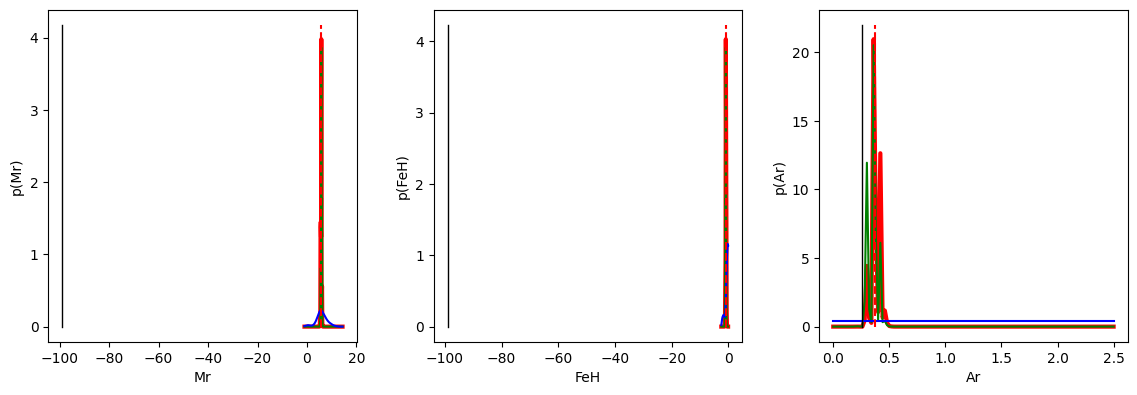

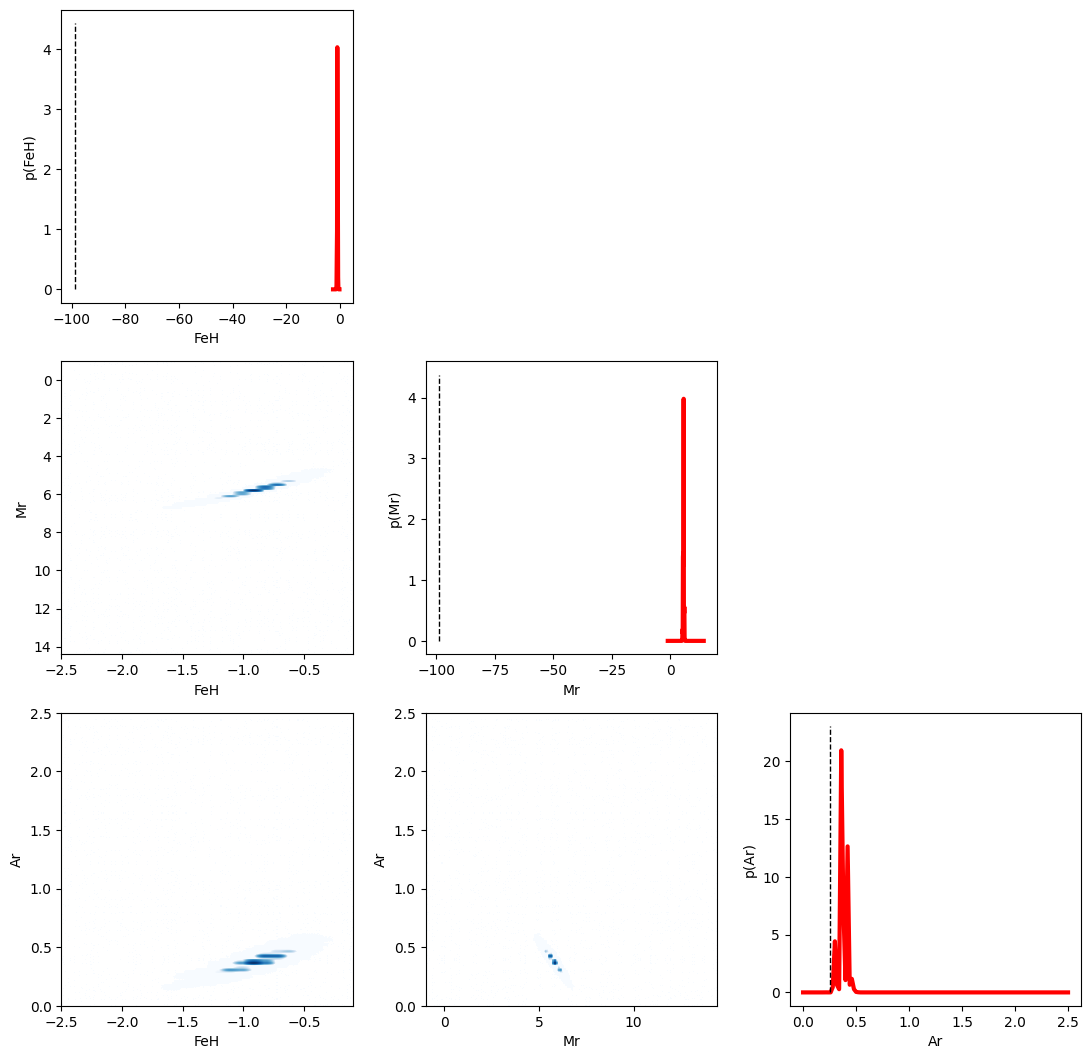

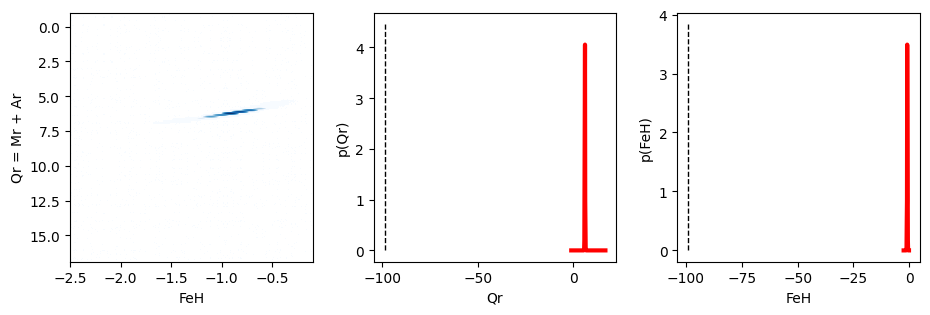

6.161519 0.13223252
Plotting star 100
pts: 25 155


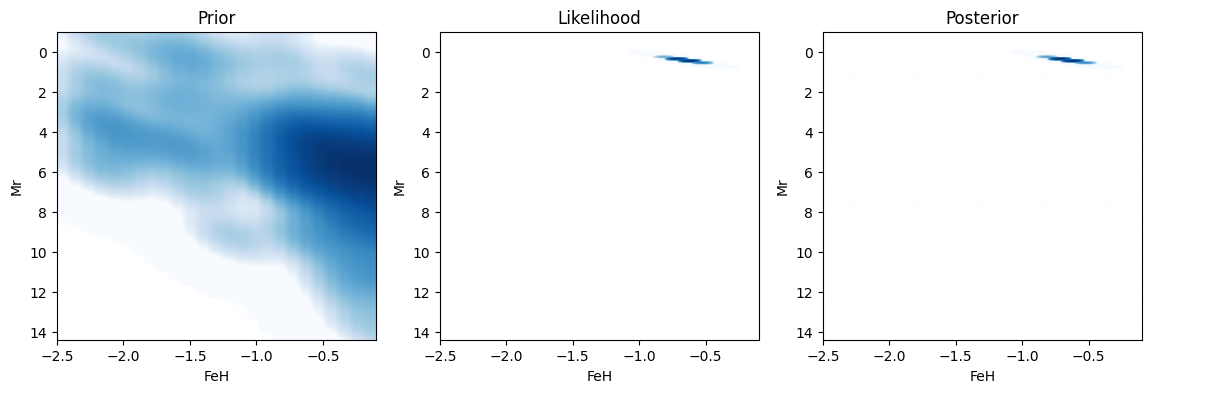

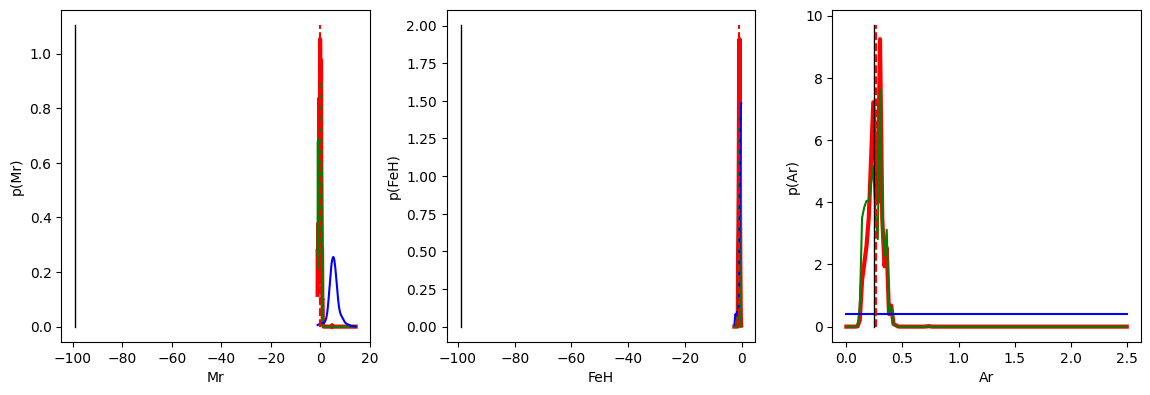

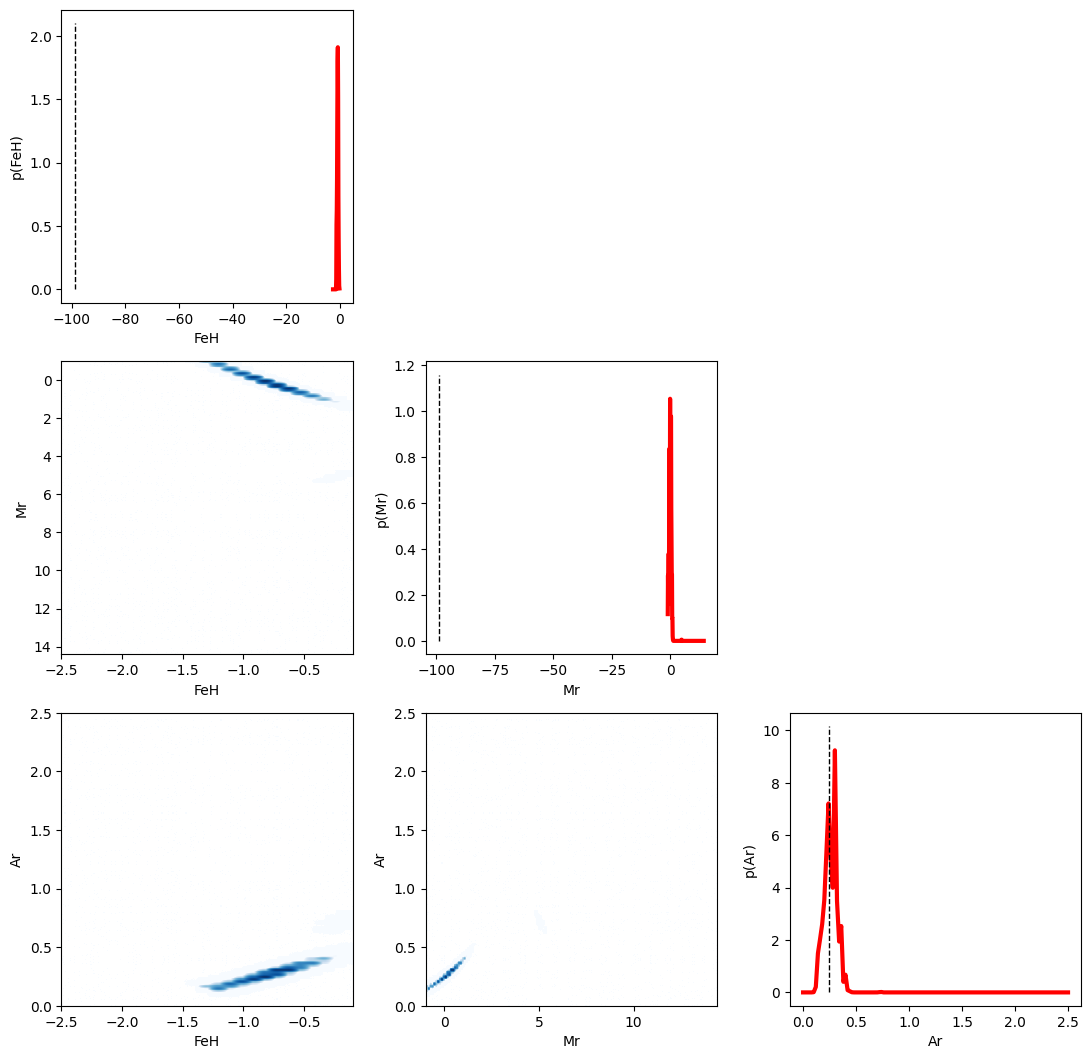

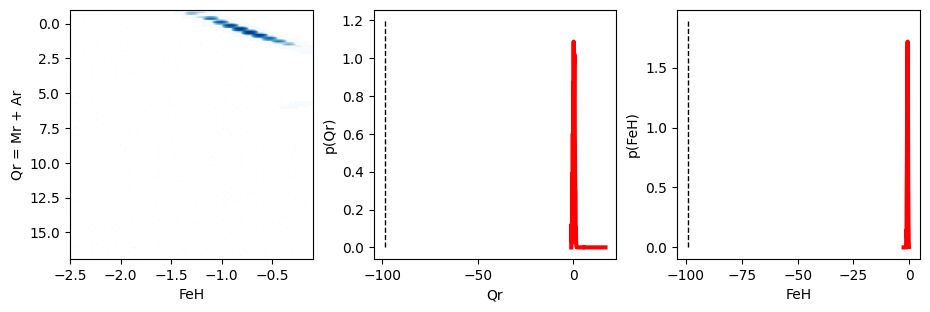

0.40190274 0.4908396


In [29]:
# Plot the results for two of the stars
bt.plot_stars(df, *results.get_plotting_args(), *global_params.get_plotting_args(), plotStars=myStars)

## Selection of representative stars

In [ ]:
s82.compute()